# Groundwater Flow Induced by Topography

The darcy flow solver, ``uw.systems.SteadyStateDarcyFlow``, can solve for ground-water flow induced by an imposed pressure-gradient. In this example we show how groundwater flow beneath hetereogeneous topography can be modelled in each of these two ways.

A simple 2D hill model is set up with 3 layers, which are assigned hydraulic and thermal properties. The values of these parameters are inferred from some synthetic observations using the neighbourhood algorithm.

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
uw.utils.matplotlib_inline()

## Set up the mesh

Initialise a Q1 finite element mesh and mesh variables

In [7]:
deformedmesh = True

elementType = "Q1"
resX = 256
resY = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (0., -12000.), 
                                 maxCoord    = (30000., 0.)) 

gwHydraulicHeadField       = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField  = mesh.add_variable( nodeDofCount=1 )
velocityField              = mesh.add_variable(nodeDofCount=2)

## Deform mesh to surface topography

We make a  hill using a defined wavelength

In [8]:
xcoords = np.linspace(0,30000,resX)
ycoords = np.linspace(-12000,0,resY)

# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -0.5

def topo_coords(x, hillsize, hillwavelength):
    return hillsize*x/4*np.cos(x*hillwavelength*np.pi)
    

In [9]:
# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -10000.

yCoordFn = uw.function.input()[1]
xCoordFn = uw.function.input()[0]

# ramp option
ydel = hillsize  * (xCoordFn )/4. * uw.function.math.cos(xCoordFn * hillwavelength * np.pi)

if deformedmesh:
    with mesh.deform_mesh():
        for i in range(len(mesh.data[:])):
            y = mesh.data[i,1]
            if y >= ydeform:
                delY = ydel.evaluate((mesh.data[i,0],mesh.data[i,1])) #0.1 * (mesh.data[i,0] + 1.)/2.
                dY = (y - ydeform)/(-ydeform) * delY

                mesh.data[i,1] += dY


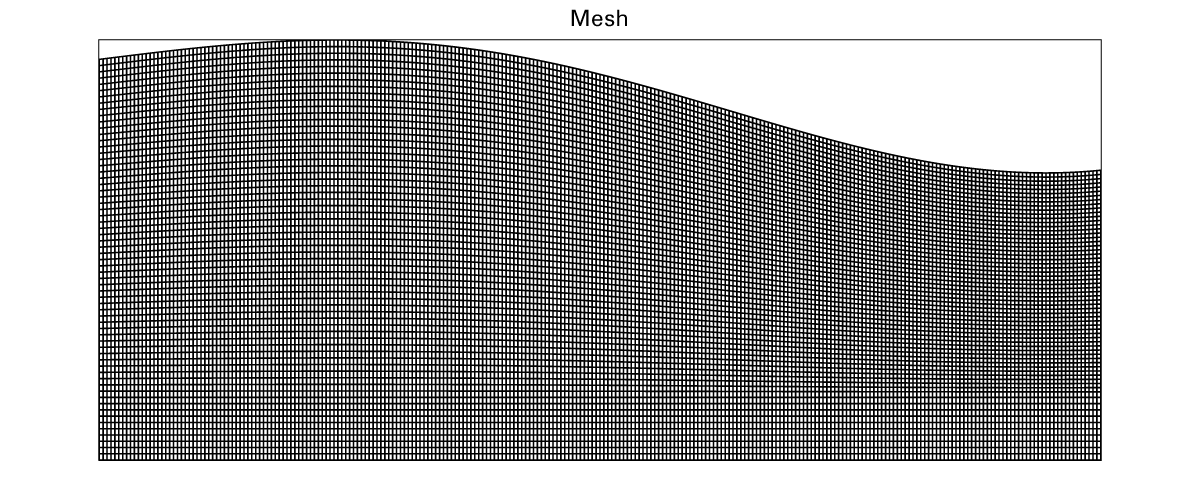

In [12]:
figMaterial = vis.Figure( figsize=(1200,500), title="Mesh" )
figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()

## Set up the types of boundary conditions

We'll set the left, right and bottom walls such that flow cannot pass through them, only parallel.
In other words for hydraulic head $h$:

$ \frac{\partial h}{\partial x}=0$ : left and right walls

$ \frac{\partial h}{\partial y}=0$ : bottom wall

This is only solvable if there is topography or a hydraulic head upper BC.

In [31]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]


gwHydraulicHeadBC = uw.conditions.DirichletCondition( variable        = gwHydraulicHeadField, 
                                                      indexSetsPerDof = ( topWall   ) )

# assign the hydraulic head upper BC to match the mesh
gwHydraulicHeadField.data[:] = yCoordFn.evaluate(mesh)

*Set initial conditions and the values of the boundary conditions. Because the upper BC is a dirichlet condition, the upper wall is constrained to the value we set now. For the rest of the domain, it is helpful to set an increasing groundwater pressure gradient, but the values will be changed during the solution.*

## Set up particle swarm

Each cell contains particles that must be assigned isotropic thermal and hydralic properties. In 2D it is fine to set only one particle per cell to prevent variations in hydaulic diffusivity within cells.

In [32]:
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=1)
swarm.populate_using_layout( layout=swarmLayout )

In [33]:
materialIndex        = swarm.add_variable( dataType="int",    count=1 )
swarmVelocity        = swarm.add_variable( dataType="double", count=2 )
hydraulicDiffusivity = swarm.add_variable( dataType="double", count=1 )

materialPorous        = 0
materialImpermeable   = 1

xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

conditions = [ (yCoordFn > -0.5, materialPorous),
               (xCoordFn < -1. , materialPorous),
               (True , materialImpermeable )]


# materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)

## Assign material properties

Each 'lithology' is assigned a material index belonging to each particle. Starting values of the hydraulic diffusivity are provided.

In [55]:
# thicknesses
matIndex = [1,2,3]
matDiffusivity = [1e-8, 1e-8, 1e-8] # uniform
zthick = [1000.0, 5000.0, 20000]

materialIndex.data[:] = 0
hydraulicDiffusivity.data[:] = 1e-12

for i in range(xcoords.size - 1):
    x0 = xcoords[i]
    x1 = xcoords[i+1]
    
    yref = float(mesh.data[topWall,1][i])
    
    mask_x = np.logical_and(swarm.data[:,0] >= x0, swarm.data[:,0] < x1)
    idx = np.nonzero(mask_x)[0]
    
    for index, dy in zip(matIndex, zthick):
        mask_y = np.logical_and(swarm.data[mask_x,1] >= yref-dy, swarm.data[mask_x,1] < yref)
        materialIndex.data[idx[mask_y]] = index
        
        yref -= dy
        
        


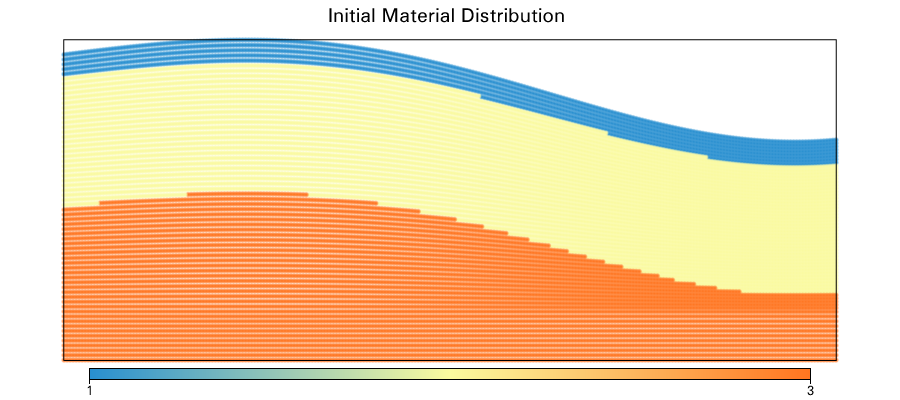

In [56]:
figMaterial = vis.Figure( figsize=(900,400), title="Initial Material Distribution" )
figMaterial.append( vis.objects.Points(swarm, materialIndex, pointSize=6.0) )
figMaterial.show()

In [57]:
# map diffusivity field using the material index

for i, index in enumerate(matIndex):
    mask_index = materialIndex.data == index
    hydraulicDiffusivity.data[mask_index] = matDiffusivity[i]
    
# project from swarm to the mesh
hydproj = uw.utils.MeshVariable_Projection(hydraulicDiffusivityField,hydraulicDiffusivity,swarm)
hydproj.solve()


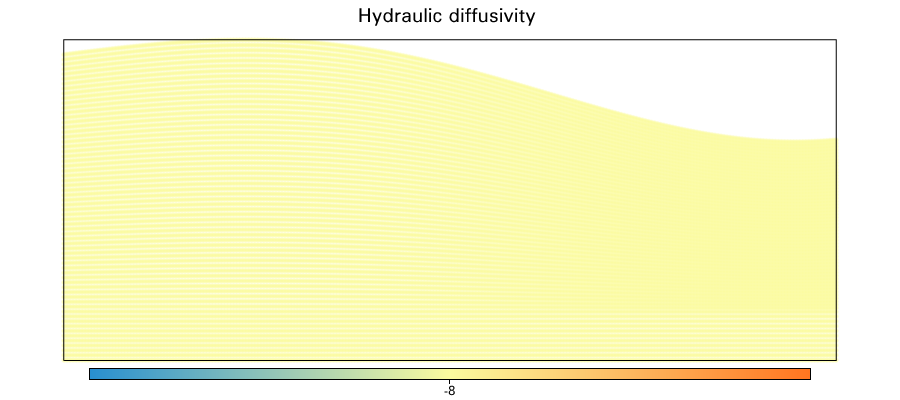

In [58]:
figMaterial = vis.Figure( figsize=(900,400), title="Hydraulic diffusivity" )
figMaterial.append( vis.objects.Points(swarm, uw.function.math.log10(hydraulicDiffusivity), pointSize=6.0) )
figMaterial.show()

*Setup groundwater equations*

In [59]:

gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                            pressureField = gwHydraulicHeadField, 
                                            fn_diffusivity = hydraulicDiffusivity,
                                            conditions=[gwHydraulicHeadBC],
                                            fn_bodyforce=(0., 0.,),
                                            voronoi_swarm=swarm,
                                            swarmVarVelocity=swarmVelocity)


gwsolver = uw.systems.Solver(gwadvDiff)

In [60]:
gwsolver.solve()

In [61]:
obs_coords = np.array([[29500.0,-6000.]])
gwHydraulicHeadField.evaluate(obs_coords)

array([[-2983.73851802]])


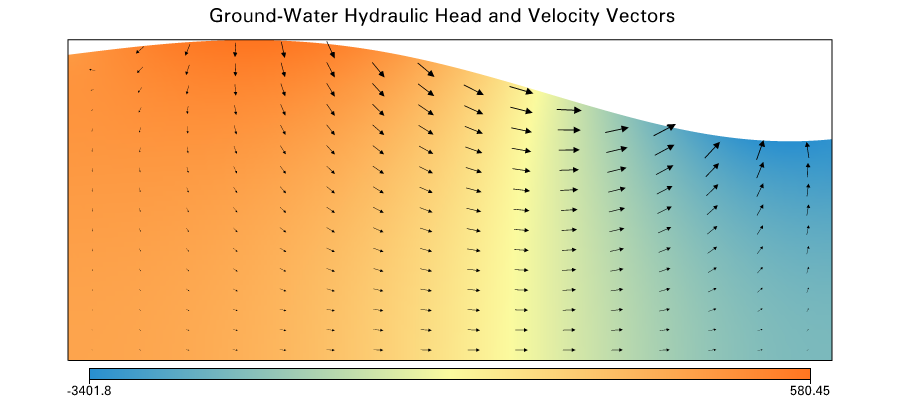

max velocity = 2.904242457935918e-09


In [62]:
figMaterial = vis.Figure( figsize=(900,400),title="Ground-Water Hydraulic Head and Velocity Vectors" )
figMaterial.append(vis.objects.Surface(mesh, gwHydraulicHeadField, onMesh=True))
scale = 0.03
figMaterial.append(vis.objects.VectorArrows(mesh,velocityField,scaling=1,arrowHead=0.3))
figMaterial.show()

print("max velocity = {}".format(np.abs(velocityField.data).max()))

## Define forward model

The forward model links the simulation with the data. First we need to create some synthetic data.

Synthetic boreholes with:

- hydraulic head
- temperature estimates
- surface recharge estimates

In [ ]:
# pressure head



In [43]:
def forward_model(x):
    kh = 10**x
    
    for i, index in enumerate(matIndex):
        mask_index = materialIndex.data == index
        hydraulicDiffusivity.data[mask_index] = kh[i]

    gwsolver.solve()
    obs_pressure = float(gwPressureField.evaluate(obs_coords))
    return (obs_pressure - 4000.0)**2



In [44]:
from scipy.optimize import minimize, differential_evolution

x0 = np.log10(matDiffusivity)
res = differential_evolution(forward_model, bounds=[(-20,-1),(-20,-1),(-20,-1)], popsize=1)

NameError: name 'gwPressureField' is not defined

In [28]:
res

     fun: 5.169878828456423e-24
 message: 'Optimization terminated successfully.'
    nfev: 464
     nit: 75
 success: True
       x: array([-6.17038867, -4.76977155, -8.43199144])

In [29]:
forward_model(x0)

349637.88426924625

In [35]:
forward_model(res.x)

5.169878828456423e-24

_export to HDF5_

In [31]:
xdmf_info_mesh  = mesh.save('mesh.h5')
xdmf_info_swarm = swarm.save('swarm.h5')

xdmf_info_matIndex = materialIndex.save('materialIndex.h5')
materialIndex.xdmf('materialIndex.xdmf', xdmf_info_matIndex, 'materialIndex', xdmf_info_swarm, 'TheSwarm')

In [32]:
for xdmf_info,save_name,save_object in [(xdmf_info_mesh, 'hydraulicDiffusivityField', hydraulicDiffusivityField),
                                        (xdmf_info_mesh, 'velocityField', velocityField),
                                        (xdmf_info_mesh, 'pressureField', gwPressureField)]:
    
    xdmf_info_var = save_object.save(save_name+'.h5')
    save_object.xdmf(save_name+'.xdmf', xdmf_info_var, save_name, xdmf_info, 'TheMesh')

*Use matplotlib to plot pressure contours and stream-lines, to produce a similar type of figure to Toth (1963).*


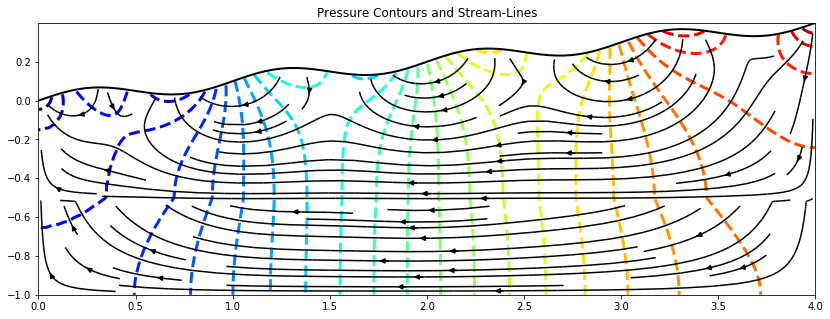

In [33]:
# If in parallel, this will only plot the data from one CPU. If you would like to make the same plot in parallel, you
#     should save the data, then do this as a post-processing step. 

if uw.mpi.rank == 0:
    if deformedmesh:
        gravterm = 1.
    else:
        gravterm = 0.


    arrXi = numpy.linspace(0,4,400)
    if deformedmesh:
        maxY = numpy.max(mesh.data[:,1])
    else:
        maxY = 0.

    arrYi = numpy.linspace(-1,maxY,100)

    maskArray = numpy.ones((len(arrXi),len(arrYi)))
    for i in range(len(arrXi)):
        for j in range(len(arrYi)):
            if arrYi[j] < ydel.evaluate(numpy.array([[arrXi[i],arrYi[j]]])):
                maskArray[i,j] = 0.

    arrX, arrY = numpy.meshgrid(arrXi, arrYi)
    arrP = interpolate.griddata((mesh.data[:,0], mesh.data[:,1]), 
                    gwPressureField.data[:,0] + gravterm*mesh.data[:,1], (arrX, arrY)).T

    arrP = numpy.ma.array(arrP,mask=maskArray)


    plt.figure(figsize=(20,5))
    plt.gca().set_aspect('equal')

    nLevels = 25
    levels = numpy.linspace(numpy.min(arrP),numpy.max(arrP),nLevels)
    plt.contour(arrX,arrY,arrP.T,levels=levels,
                linewidths=numpy.ones(nLevels)*3,linestyles="dashed",cmap=plt.cm.jet )

    hillX = numpy.linspace(0,4,100)
    hillY = ydel.evaluate(numpy.vstack([hillX,numpy.zeros(100)]).T)
    plt.plot(hillX,hillY,c="black",lw=2)

    arrU = interpolate.griddata((swarm.particleCoordinates.data[:,0], swarm.particleCoordinates.data[:,1]), 
                                swarmVelocity.data[:,0], (arrX, arrY)).T
    arrV = interpolate.griddata((swarm.particleCoordinates.data[:,0], swarm.particleCoordinates.data[:,1]), 
                                swarmVelocity.data[:,1], (arrX, arrY)).T

    arrU = numpy.ma.array(arrU,mask=maskArray)
    arrP = numpy.ma.array(arrP,mask=maskArray)
    plt.streamplot(arrXi,arrYi,arrU.T,arrV.T,color="black")

    plt.title('Pressure Contours and Stream-Lines')
    plt.savefig('PressureContours_StreamLines.png',bbox_inches="tight")

Here are some metrics, notice that there is a slight change depending on whether or not the deformed mesh / gravity term combination is used.

In [18]:
# If in parallel, every CPU will report these metrics for its own domain.
print("Max horiz. velocity: %.4e" %numpy.max(abs(swarmVelocity.data[:,0])))
print("Max vert. velocity: %.4e" %numpy.max(abs(swarmVelocity.data[:,1])))
print("Max pressure: %.4e" %numpy.max(gwPressureField.data[:]))
print("Min pressure: %.4e" %numpy.min(gwPressureField.data[:]))

Max horiz. velocity: 4.2897e-01
Max vert. velocity: 7.1046e-01
Max pressure: 1.2926e+00
Min pressure: -0.0000e+00


In [19]:
# This cell is for testing purposes. It ensures the example computes the expected flow velocity rms values
import numpy as np
integrands = (uw.function.math.dot( velocityField, velocityField ), 1.)
v2, vol    = mesh.integrate(integrands)
vrms       = np.sqrt(v2/vol)
if not np.isclose(vrms, 7.38895709e-02):
    raise RuntimeError("The Velocity RMS is not close")

RuntimeError: The Velocity RMS is not close

In [ ]:
print("This model was run successfully to completion using underworld {}".format(uw.__version__))